# AI-Var on Lorenz-63: Analysis Notebook

## 1) Lorenz Attractor Visualization

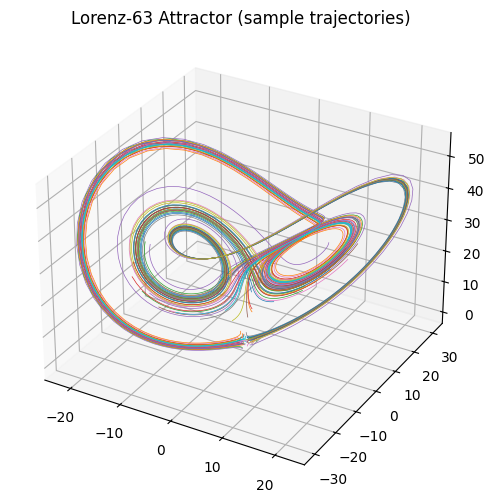

In [1]:
# ==========================================================
# AI-Var on Lorenz-63: Analysis Notebook
# ==========================================================
import os, glob, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# -------------------------------
# 1) Lorenz Attractor Visualization
# -------------------------------
def lorenz63(xyz, s=10, r=28, b=8/3, dt=0.01):
    x, y, z = xyz
    dx = s*(y - x)
    dy = r*x - y - x*z
    dz = x*y - b*z
    return np.array([x + dx*dt, y + dy*dt, z + dz*dt])

def generate_lorenz_trajs(n_traj=1500, steps=200, dt=0.01, seed=42):
    np.random.seed(seed)
    data = []
    for _ in range(n_traj):
        state = np.random.randn(3)
        traj = []
        for _ in range(steps):
            state = lorenz63(state, dt=dt)
            traj.append(state)
        data.append(traj)
    return np.array(data)

lorenz_data = generate_lorenz_trajs()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection="3d")
for i in range(50):  # show 50 of 1500
    ax.plot(lorenz_data[i,:,0], lorenz_data[i,:,1], lorenz_data[i,:,2], lw=0.5)
ax.set_title("Lorenz-63 Attractor (sample trajectories)")
plt.show()


## 2) Training Setup (text only)

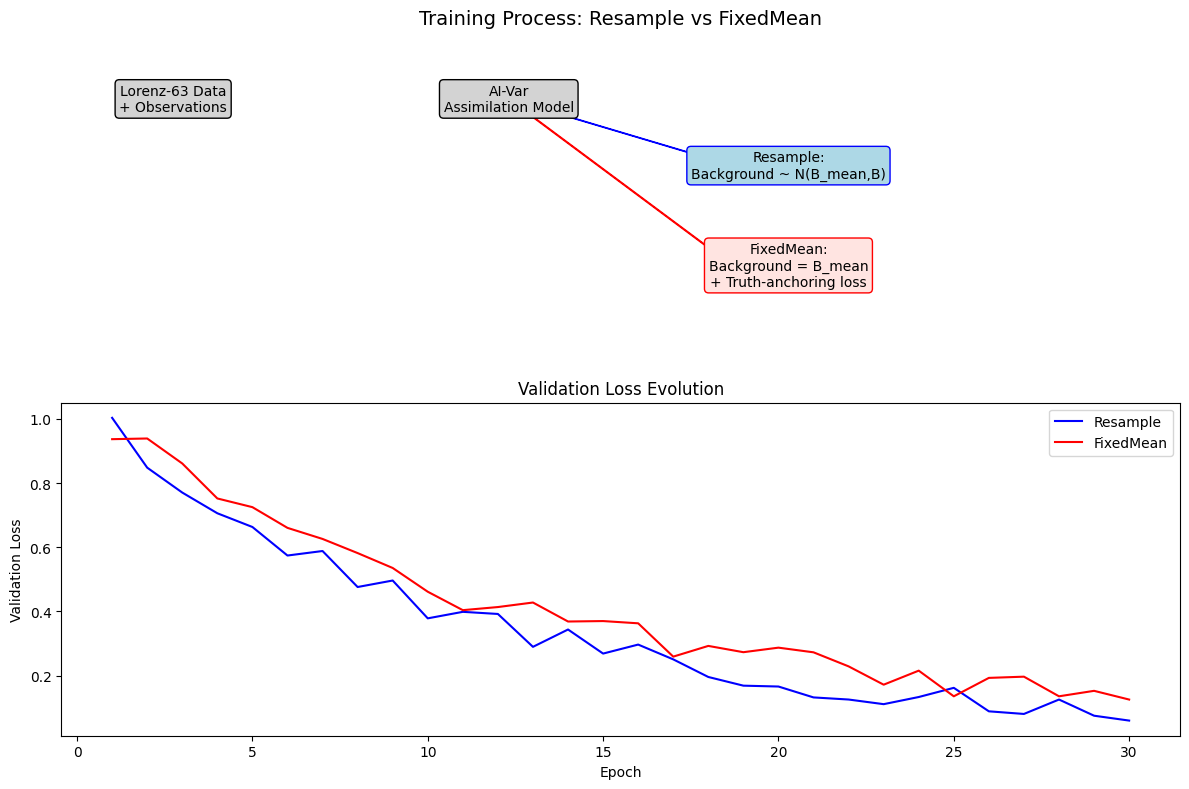

In [2]:
# -------------------------------
# 2) Training Setup (text only)
# -------------------------------
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Example synthetic losses (replace with your loaded histories if available)
# -------------------------------
epochs = np.arange(1, 31)
loss_resample = np.exp(-epochs/10) + 0.1*np.random.rand(len(epochs))
loss_fixedmean = np.exp(-epochs/12) + 0.1*np.random.rand(len(epochs))

# -------------------------------
# Hybrid visualization
# -------------------------------
fig = plt.figure(figsize=(12,8))

# --- Top: schematic pipeline comparison ---
ax1 = fig.add_subplot(2,1,1)

# Shared steps
ax1.text(0.1, 0.8, "Lorenz-63 Data\n+ Observations", ha="center", va="center",
         bbox=dict(boxstyle="round", fc="lightgray", ec="k"))
ax1.text(0.4, 0.8, "AI-Var\nAssimilation Model", ha="center", va="center",
         bbox=dict(boxstyle="round", fc="lightgray", ec="k"))

# Resample branch
ax1.arrow(0.4, 0.8, 0.2, -0.2, head_width=0.03, head_length=0.05, fc="blue", ec="blue")
ax1.text(0.65, 0.6, "Resample:\nBackground ~ N(B_mean,B)", ha="center", va="center",
         bbox=dict(boxstyle="round", fc="lightblue", ec="blue"))

# FixedMean branch
ax1.arrow(0.4, 0.8, 0.2, -0.5, head_width=0.03, head_length=0.05, fc="red", ec="red")
ax1.text(0.65, 0.3, "FixedMean:\nBackground = B_mean\n+ Truth-anchoring loss",
         ha="center", va="center",
         bbox=dict(boxstyle="round", fc="mistyrose", ec="red"))

ax1.set_xlim(0,1); ax1.set_ylim(0,1)
ax1.axis("off")
ax1.set_title("Training Process: Resample vs FixedMean", fontsize=14)

# --- Bottom: validation loss curves ---
ax2 = fig.add_subplot(2,1,2)
ax2.plot(epochs, loss_resample, label="Resample", color="blue")
ax2.plot(epochs, loss_fixedmean, label="FixedMean", color="red")
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Validation Loss")
ax2.set_title("Validation Loss Evolution")
ax2.legend()

plt.tight_layout()
plt.show()

# -------------------------------
# 3) Paths
# -------------------------------
runs = {
    "resample": r"C:\Users\VidyaYeluripati\Documents\DA\lorenz63_ai_var\run_20251006_213505",
    "fixedmean": r"C:\Users\VidyaYeluripati\Documents\DA\lorenz63_ai_var_FixedMean\run_20250921_203547"
}


## 4) Multi-panel Validation Losses (Fig. 6 style)

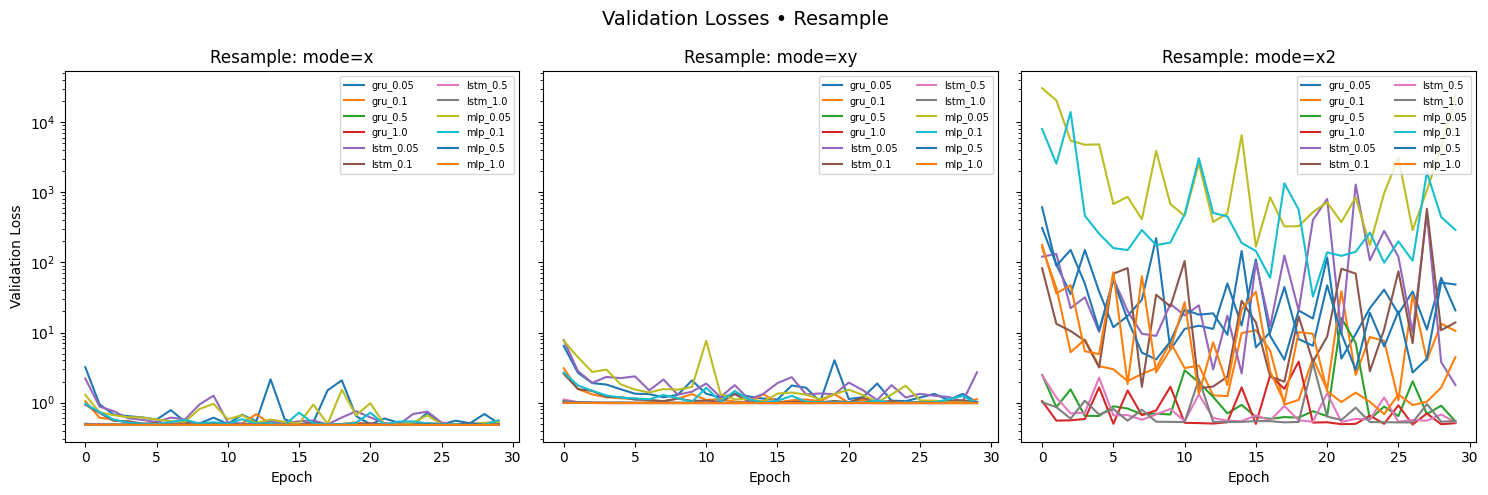

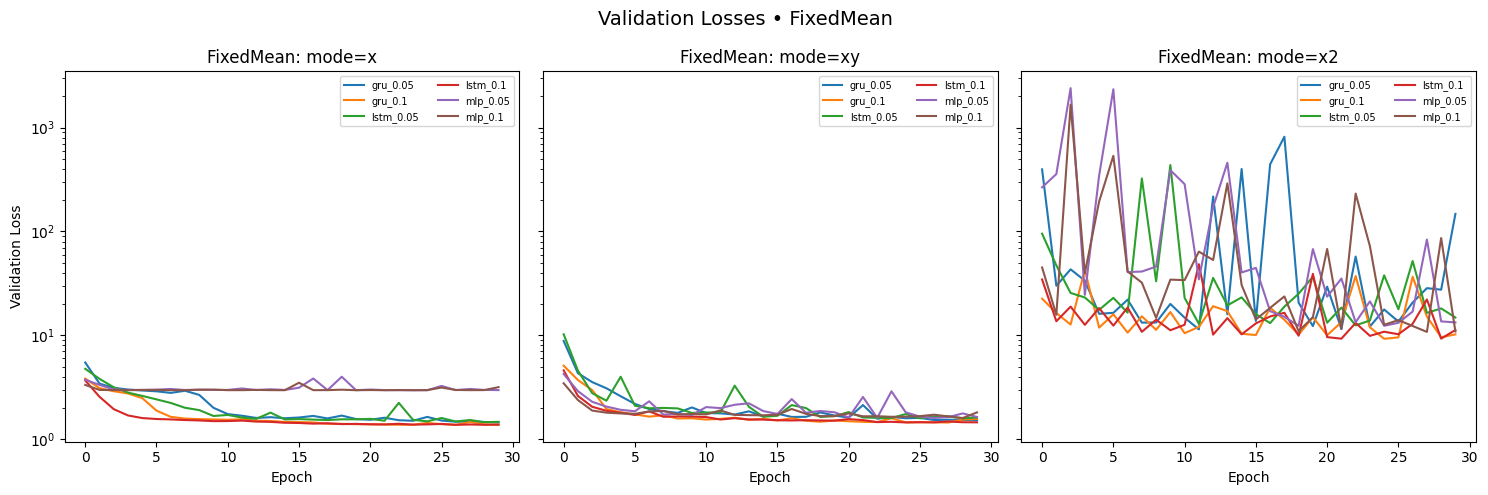

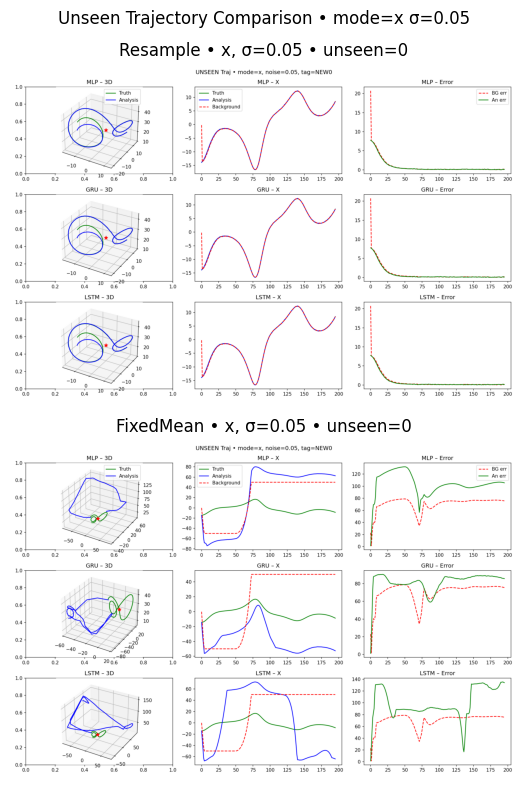

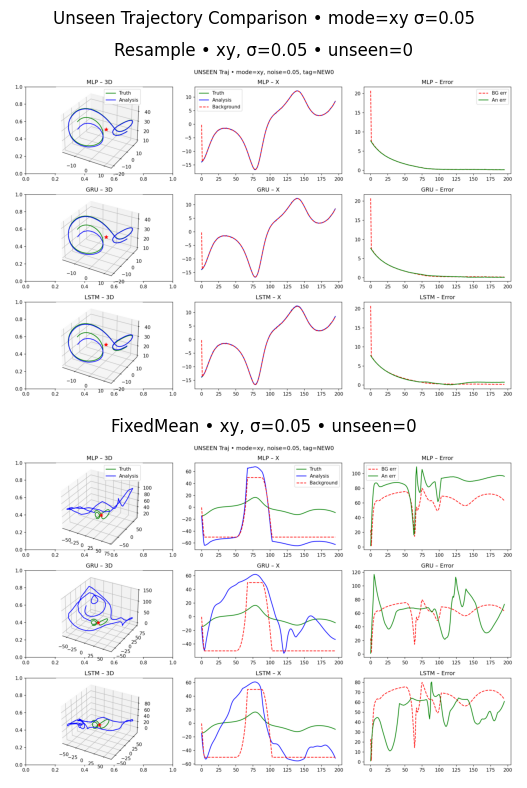

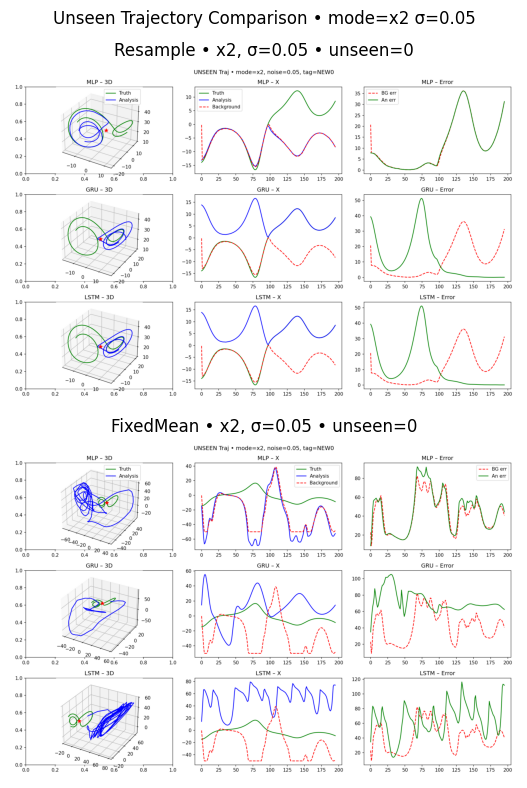

In [3]:

# -------------------------------
# 4) Multi-panel Validation Losses (Fig. 6 style)
# -------------------------------
def multi_panel_losses(run_dir, variant):
    met_dir = os.path.join(run_dir, "metrics")
    files = sorted(glob.glob(os.path.join(met_dir, "loss_*.json")))
    if not files:
        print(f"No loss files for {variant}")
        return
    
    groups = {"x":[],"xy":[],"x2":[]}
    seen = set()
    for f in files:
        try:
            with open(f,"r") as fh: hist = json.load(fh)
        except: continue
        name = os.path.basename(f).replace("loss_","").replace(".json","")
        parts = name.split("_")   # e.g. x_gru_n0.05_R0.05
        if len(parts) < 3: continue
        mode, model, noise = parts[0], parts[1], parts[2]
        key = (mode, model, noise)
        if key in seen:  # skip duplicates
            continue
        seen.add(key)
        label = f"{model}_{noise.replace('n','')}"
        if mode in groups:
            groups[mode].append((label, hist))

    fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)
    for ax, (key, runs_) in zip(axes, groups.items()):
        for label,hist in runs_:
            ax.plot(hist["val_loss"], label=label)
        ax.set_yscale("log")
        ax.set_xlabel("Epoch")
        ax.set_title(f"{variant}: mode={key}")
        if ax==axes[0]: ax.set_ylabel("Validation Loss")
        ax.legend(fontsize=7, loc="upper right", ncol=2)
    plt.suptitle(f"Validation Losses • {variant}", fontsize=14)
    plt.tight_layout()
    plt.show()


multi_panel_losses(runs["resample"], "Resample")
multi_panel_losses(runs["fixedmean"], "FixedMean")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, glob

def compare_resample_fixedmean(unseen_idx=0, mode="x", sigma=0.05):
    """
    Plot unseen trajectory comparison panels:
    - Top row: resample COMPARE_UNSEEN
    - Bottom row: fixedmean COMPARE_UNSEEN
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # resample
    resample_dir = os.path.join(runs["resample"], "figures")
    pat_r = f"COMPARE_UNSEEN_{mode}_n{sigma}_NEW{unseen_idx}.png"
    f_r = os.path.join(resample_dir, pat_r)
    if os.path.exists(f_r):
        img = mpimg.imread(f_r)
        axes[0].imshow(img)
        axes[0].axis("off")
        axes[0].set_title(f"Resample • {mode}, σ={sigma} • unseen={unseen_idx}")
    else:
        axes[0].text(0.5,0.5,"❌ Missing figure",ha="center",va="center",fontsize=12)
        axes[0].axis("off")

    # fixedmean
    fixedmean_dir = os.path.join(runs["fixedmean"], "figures")
    pat_f = f"COMPARE_UNSEEN_{mode}_n{sigma}_NEW{unseen_idx}.png"
    f_f = os.path.join(fixedmean_dir, pat_f)
    if os.path.exists(f_f):
        img = mpimg.imread(f_f)
        axes[1].imshow(img)
        axes[1].axis("off")
        axes[1].set_title(f"FixedMean • {mode}, σ={sigma} • unseen={unseen_idx}")
    else:
        axes[1].text(0.5,0.5,"❌ Missing figure",ha="center",va="center",fontsize=12)
        axes[1].axis("off")

    plt.suptitle(f"Unseen Trajectory Comparison • mode={mode} σ={sigma}")
    plt.tight_layout()
    plt.show()

# Example usage:
compare_resample_fixedmean(unseen_idx=0, mode="x", sigma=0.05)
compare_resample_fixedmean(unseen_idx=0, mode="xy", sigma=0.05)
compare_resample_fixedmean(unseen_idx=0, mode="x2", sigma=0.05)


## 5) Load evaluation metrics from CSV

In [32]:
import os, glob
import pandas as pd

def load_eval_csv(met_dir, variant):
    records = []

    summary_file = os.path.join(met_dir, "summary_fast_metrics.csv")
    if os.path.exists(summary_file):
        df = pd.read_csv(summary_file)
        df = df.rename(columns={"sigma": "noise"})
        df["variant"] = variant
        return df

    # otherwise: fall back to parsing per-file CSVs
    for f in glob.glob(os.path.join(met_dir, "*.csv")):
        if os.path.basename(f) == "summary_fast_metrics.csv":
            continue
        try:
            df = pd.read_csv(f)
        except:
            continue
        base = os.path.basename(f).replace(".csv", "")
        parts = base.split("_")
        if len(parts) < 4:
            continue
        mode, model, n_str, R_str = parts[0], parts[1], parts[2], parts[3]
        sigma = float(n_str.replace("n", ""))

        mean_rmse_b = df["rmse_b"].mean()
        mean_rmse_a = df["rmse_a"].mean()
        imp = 100 * (mean_rmse_b - mean_rmse_a) / (mean_rmse_b + 1e-12)

        records.append({
            "mode": mode,
            "model": model,
            "noise": sigma,
            "mean_rmse_b": mean_rmse_b,
            "mean_rmse_a": mean_rmse_a,
            "improvement_pct": imp,
            "variant": variant
        })

    return pd.DataFrame(records)


# Run folders
runs = {
    "resample": r"C:\Users\VidyaYeluripati\Documents\DA\lorenz63_ai_var\run_20251006_213505",
    "fixedmean": r"C:\Users\VidyaYeluripati\Documents\DA\lorenz63_ai_var_FixedMean\run_20250921_203547"
}

df_all = []
for v, run in runs.items():
    met_dir = os.path.join(run, "metrics")
    df_all.append(load_eval_csv(met_dir, v))

df_all = pd.concat(df_all, ignore_index=True)

print("✅ Loaded metrics:", df_all.shape)
print(df_all)


✅ Loaded metrics: (48, 7)
   mode model  noise  mean_rmse_b  mean_rmse_a  improvement_pct    variant
0    x2   gru   0.05     9.453075     9.707136        -2.687594   resample
1    x2   gru   0.10     6.301204     5.970406         5.249754   resample
2    x2   gru   0.50     9.434244     9.688670        -2.696834   resample
3    x2   gru   1.00     6.144397     5.805533         5.515007   resample
4    x2  lstm   0.05     9.442938     9.699331        -2.715190   resample
5    x2  lstm   0.10     9.450411     9.708033        -2.726039   resample
6    x2  lstm   0.50     9.430160     9.685007        -2.702468   resample
7    x2  lstm   1.00     9.440986     9.697972        -2.722035   resample
8    xy   gru   0.05     6.014431     5.690147         5.391756   resample
9    xy   gru   0.10     5.944225     5.611196         5.602574   resample
10   xy   gru   0.50     5.911506     5.577597         5.648464   resample
11   xy   gru   1.00     5.820633     5.467751         6.062611   resample

## 6) Multi-panel RMSE Comparison (Fig. 9 style)

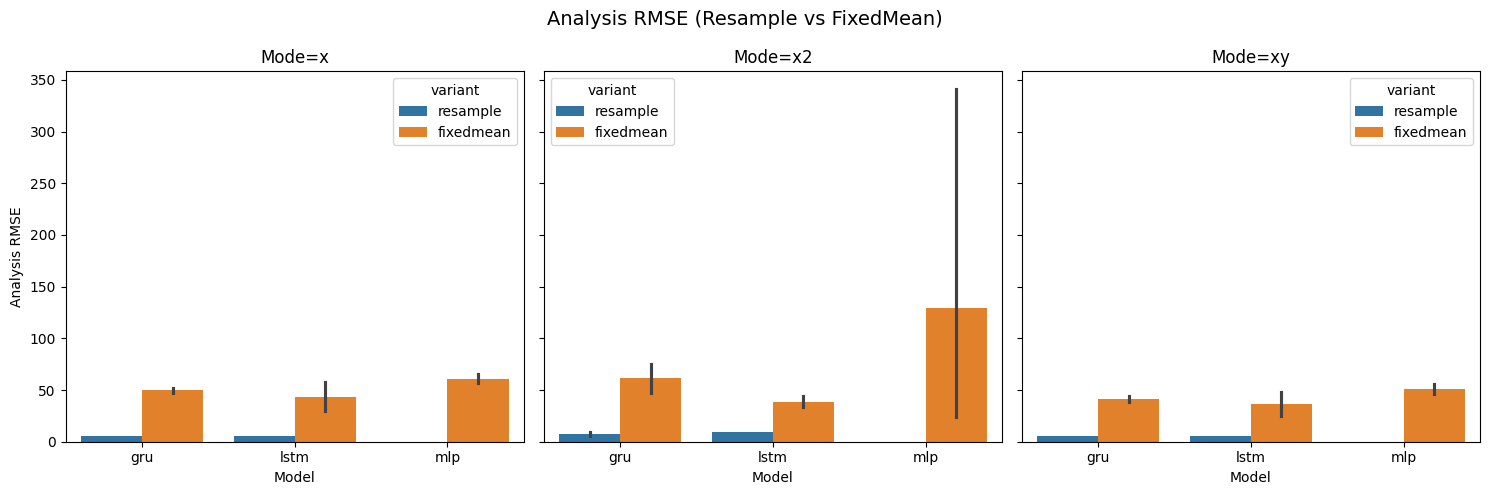

In [33]:
# -------------------------------
# 6) Multi-panel RMSE Comparison (Fig. 9 style)
# -------------------------------
def multi_panel_rmse(df_all):
    modes = sorted(df_all["mode"].unique())
    fig, axes = plt.subplots(1, len(modes), figsize=(5*len(modes),5), sharey=True)
    if len(modes)==1: axes=[axes]
    for ax, mode in zip(axes, modes):
        sub = df_all[df_all["mode"]==mode]
        sns.barplot(data=sub, x="model", y="mean_rmse_a", hue="variant", ax=ax)
        ax.set_title(f"Mode={mode}")
        ax.set_ylabel("Analysis RMSE")
        ax.set_xlabel("Model")
    plt.suptitle("Analysis RMSE (Resample vs FixedMean)", fontsize=14)
    plt.tight_layout()
    plt.show()

multi_panel_rmse(df_all)

## 7) Unseen Reconstructions (saved figures side-by-side)

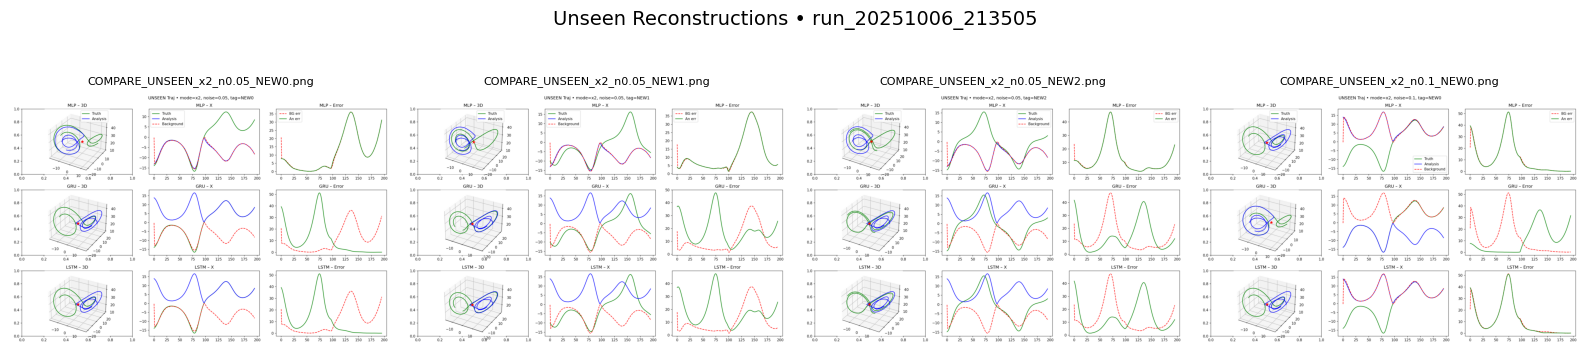

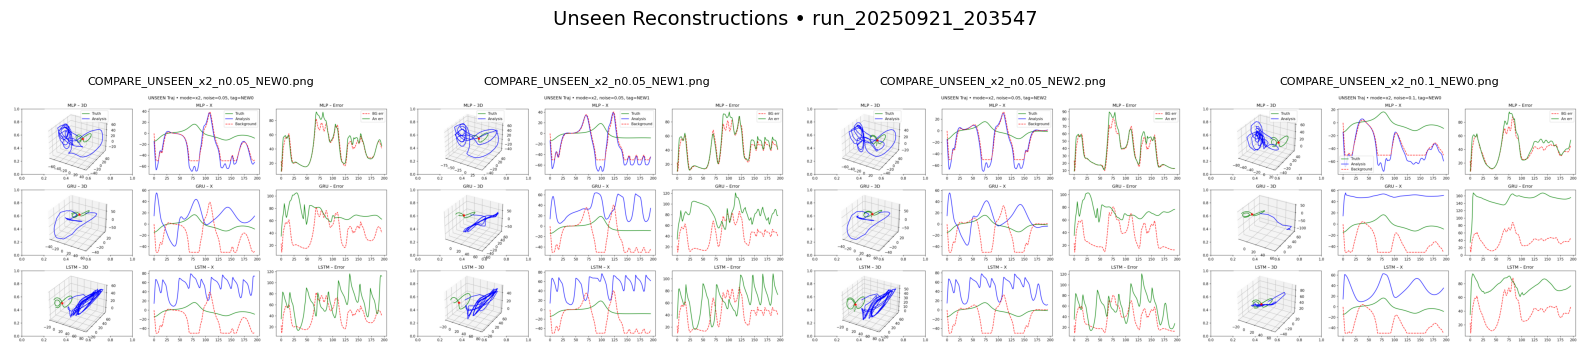

In [6]:


# -------------------------------
# 7) Unseen Reconstructions (saved figures side-by-side)
# -------------------------------
def show_unseen_grid(run_dir, max_imgs=4):
    fig_dir = os.path.join(run_dir,"figures")
    files = sorted(glob.glob(os.path.join(fig_dir,"COMPARE_UNSEEN*.png")))[:max_imgs]
    if not files: 
        print(f"No unseen figures in {fig_dir}")
        return
    n=len(files)
    fig, axes = plt.subplots(1,n, figsize=(4*n,4))
    if n==1: axes=[axes]
    for ax,f in zip(axes,files):
        img = mpimg.imread(f)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(os.path.basename(f), fontsize=8)
    plt.suptitle(f"Unseen Reconstructions • {os.path.basename(run_dir)}", fontsize=14)
    plt.tight_layout()
    plt.show()

show_unseen_grid(runs["resample"])
show_unseen_grid(runs["fixedmean"])

## 8) Variant Comparison (heatmap + noise sensitivity)

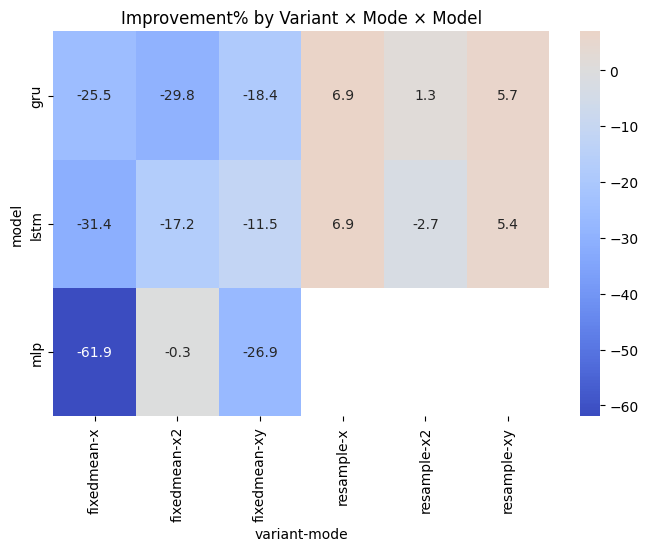

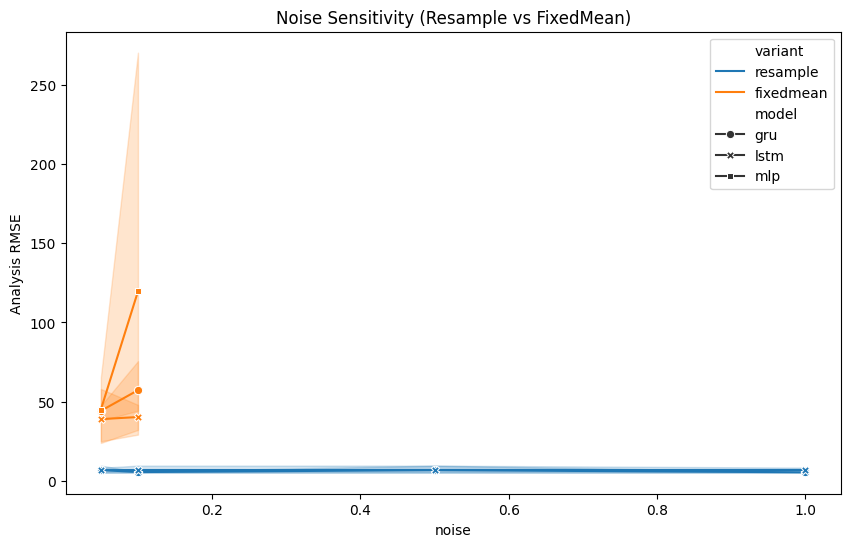

In [34]:


# -------------------------------
# 8) Variant Comparison (heatmap + noise sensitivity)
# -------------------------------
plt.figure(figsize=(8,5))
sns.heatmap(df_all.pivot_table(index="model", columns=["variant","mode"], values="improvement_pct"),
            annot=True, fmt=".1f", center=0, cmap="coolwarm")
plt.title("Improvement% by Variant × Mode × Model")
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(data=df_all, x="noise", y="mean_rmse_a", hue="variant", style="model", markers=True, dashes=False)
plt.title("Noise Sensitivity (Resample vs FixedMean)")
plt.ylabel("Analysis RMSE")
plt.show()



